In [2]:
import tensorflow as tf
import tensorflow_io as tfio
import keras
from keras import layers
from keras.layers import Dense
from keras.models import Sequential, load_model
from sklearn.model_selection import train_test_split
import numpy as np
import pathlib
import librosa
import os
import seaborn as sns
from IPython import display
import matplotlib.pyplot as plt

In [4]:
train_file = os.path.join('WakeProcessor', 'Data', 'Homebot', 'rec0.wav')
empty_file = os.path.join('WakeProcessor', 'Data', 'Empty', 'NONE0.wav')

In [5]:
def load_wav(filename):
    file_contents = tf.io.read_file(filename)
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
    
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return wav

In [6]:
wave = load_wav(train_file)
nwave = load_wav(empty_file)

In [7]:
POS = os.path.join('WakeProcessor', 'Data', 'Homebot')
NEG = os.path.join('WakeProcessor', 'Data', 'Empty')

In [8]:
pos = tf.data.Dataset.list_files(POS +'/*.wav')
neg = tf.data.Dataset.list_files(NEG +'/*.wav')

In [9]:
positives = tf.data.Dataset.zip((pos, tf.data.Dataset.from_tensor_slices(tf.ones(len(pos)))))
negatives = tf.data.Dataset.zip((neg, tf.data.Dataset.from_tensor_slices(tf.zeros(len(neg)))))
                                
data = positives.concatenate(negatives)

In [10]:
lengths = []
for file in os.listdir(os.path.join('WakeProcessor', 'Data', 'Homebot')):
    tensor_wave = load_wav(os.path.join('WakeProcessor', 'Data', 'Homebot', file))
    lengths.append(len(tensor_wave))

In [79]:
tf.math.reduce_mean(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=47925>

In [80]:
tf.math.reduce_min(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=47925>

In [82]:
tf.math.reduce_max(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=47925>

In [11]:
def preprocess(file_path, label):
    wav = load_wav(file_path)
    wav = wav[:48000]
    zero_padding = tf.zeros([48000] - tf.shape(wav), dtype=tf.float32)
    wav = tf.concat([zero_padding, wav],0)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram, label

b'WakeProcessor\\Data\\Homebot\\HOMEBOT88.wav'


<function matplotlib.pyplot.show(close=None, block=None)>

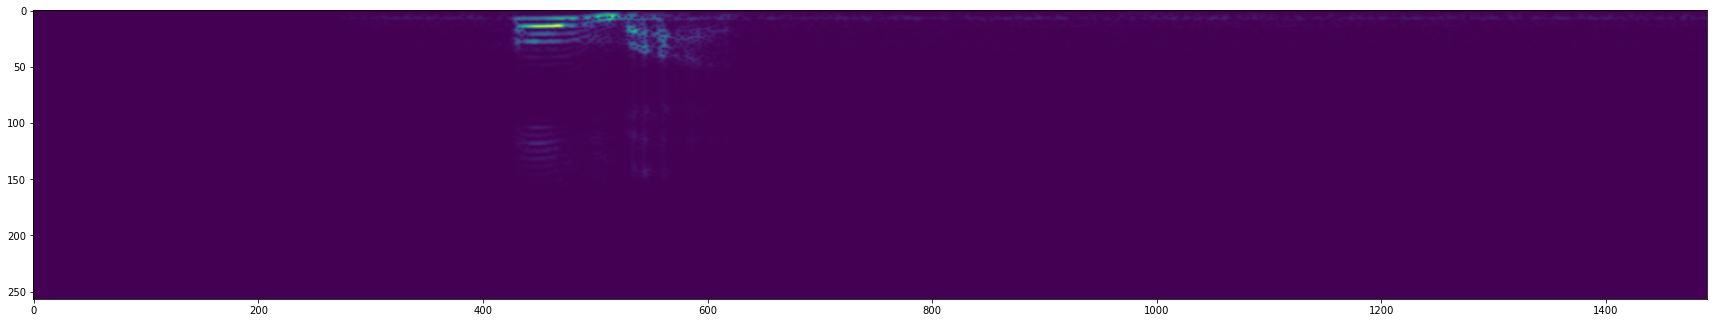

In [12]:
filepath, label = positives.shuffle(buffer_size=10000).as_numpy_iterator().next()
spectrogram, label = preprocess(filepath, label)
print(filepath)
plt.figure(figsize=(30,20))
plt.imshow(tf.transpose(spectrogram)[0])
plt.show

In [13]:
data = data.map(preprocess)
data = data.cache()
data = data.shuffle(buffer_size=1000)
data = data.batch(16)
data = data.prefetch(8)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [14]:
#Amount to take for train
len(data)

8

In [15]:
#Amount to take for test
len(data)*.2

1.6

In [16]:
train = data.take(8)
test = data.skip(8).take(1)

In [17]:
samples, labels = train.as_numpy_iterator().next()
samples.shape

(16, 1491, 257, 1)

In [18]:
from tensorflow.keras.layers import Conv2D, Dense, Flatten

In [19]:
model = Sequential()
#Update input shape
model.add(Conv2D(16, (3,3), activation='relu', input_shape=(1491, 257, 1)))
#Optional max pooling
model.add(Conv2D(16, (3,3), activation='relu'))
#Optional max pooling
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [20]:
model.compile('Adam', loss='BinaryCrossentropy', metrics=[tf.keras.metrics.Recall(), tf.keras.metrics.Precision()])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 1489, 255, 16)     160       
                                                                 
 conv2d_1 (Conv2D)           (None, 1487, 253, 16)     2320      
                                                                 
 flatten (Flatten)           (None, 6019376)           0         
                                                                 
 dense (Dense)               (None, 128)               770480256 
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 770,482,865
Trainable params: 770,482,865
Non-trainable params: 0
_________________________________________________________________


In [21]:
hist = model.fit(train, epochs=10,validation_data=test)

Epoch 1/10
8/8 [==============================] - 493s 59s/step - loss: 0.1612 - recall: 0.8829 - precision: 0.9899
Epoch 2/10
8/8 [==============================] - 614s 59s/step - loss: 0.0214 - recall: 1.0000 - precision: 1.0000
Epoch 3/10
8/8 [==============================] - 408s 51s/step - loss: 0.0575 - recall: 1.0000 - precision: 0.9737
Epoch 4/10
8/8 [==============================] - 407s 51s/step - loss: 0.0284 - recall: 1.0000 - precision: 0.9737
Epoch 5/10
8/8 [==============================] - 430s 54s/step - loss: 0.0188 - recall: 1.0000 - precision: 0.9737
Epoch 6/10
8/8 [==============================] - 334s 41s/step - loss: 0.0184 - recall: 1.0000 - precision: 0.9737
Epoch 7/10
8/8 [==============================] - 346s 44s/step - loss: 0.0183 - recall: 1.0000 - precision: 0.9911
Epoch 8/10
8/8 [==============================] - 316s 39s/step - loss: 0.0183 - recall: 1.0000 - precision: 1.0000
Epoch 9/10
8/8 [==============================] - 304s 38s/step - loss: 

In [22]:
model.save("processor.h5")

In [28]:
from glob import glob
import IPython.display as ipd

In [29]:
audio_files = glob('WakeProcessor/Data/Homebot/*')

In [30]:
ipd.Audio(audio_files[0])

In [70]:
HB = os.path.join('WakeProcessor', 'Data', 'Homebot')
EM = os.path.join('WakeProcessor', 'Data', 'Empty')

pos = tf.data.Dataset.list_files(HB +'/*.wav')
neg = tf.data.Dataset.list_files(EM +'/*.wav')

homebot = tf.data.Dataset.zip((pos, tf.data.Dataset.from_tensor_slices(tf.ones(len(pos)))))
empty = tf.data.Dataset.zip((neg, tf.data.Dataset.from_tensor_slices(tf.zeros(len(neg)))))

ds = homebot.concatenate(empty)


In [74]:
test_audio = []
test_labels = []

for audio, label in ds:
    test_audio.append(audio.numpy())
    test_labels.append(label.numpy())
test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

In [75]:
y_pred = np.argmax(md.predict(test_audio), axis=1)
y_true = test_labels

ValueError: in user code:

    File "C:\Users\ograd\anaconda3\lib\site-packages\keras\engine\training.py", line 2137, in predict_function  *
        return step_function(self, iterator)
    File "C:\Users\ograd\anaconda3\lib\site-packages\keras\engine\training.py", line 2123, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\ograd\anaconda3\lib\site-packages\keras\engine\training.py", line 2111, in run_step  **
        outputs = model.predict_step(data)
    File "C:\Users\ograd\anaconda3\lib\site-packages\keras\engine\training.py", line 2079, in predict_step
        return self(x, training=False)
    File "C:\Users\ograd\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\ograd\anaconda3\lib\site-packages\keras\engine\input_spec.py", line 250, in assert_input_compatibility
        raise ValueError(

    ValueError: Exception encountered when calling layer 'sequential' (type Sequential).
    
    Input 0 of layer "conv2d" is incompatible with the layer: expected min_ndim=4, found ndim=1. Full shape received: (None,)
    
    Call arguments received by layer 'sequential' (type Sequential):
      • inputs=tf.Tensor(shape=(None,), dtype=string)
      • training=False
      • mask=None


In [68]:
filepath, label = ds.shuffle(buffer_size=10000).as_numpy_iterator().next()
spectrogram, label = preprocess(filepath, label)
print(filepath)
plt.figure(figsize=(30,20))
plt.imshow(tf.transpose(spectrogram)[0])
plt.show

AttributeError: 'str' object has no attribute 'shuffle'

In [61]:
ds = ds.map(preprocess)
ds = ds.cache()
ds = ds.shuffle(buffer_size=1000)
ds = ds.batch(16)
ds = ds.prefetch(8)

In [38]:
md = keras.models.load_model("processor.h5")

In [66]:
prediction = md.predict(ds)

8/8 [==============================] - 4s 495ms/step


In [63]:
prediction

array([[0.9999999 ],
       [0.99999726],
       [1.        ],
       [0.9999998 ],
       [1.        ],
       [1.        ],
       [0.99982935],
       [1.        ],
       [1.        ],
       [0.9999999 ],
       [0.9999992 ],
       [0.99999976],
       [0.9999941 ],
       [0.99998826],
       [0.9997    ],
       [0.9999937 ],
       [0.99999744],
       [0.9999279 ],
       [1.        ],
       [0.9999992 ],
       [0.9990891 ],
       [1.        ],
       [1.        ],
       [0.9999965 ],
       [1.        ],
       [1.        ],
       [0.9999999 ],
       [0.99999344],
       [0.9999218 ],
       [1.        ],
       [0.99990684],
       [0.99998426],
       [1.        ],
       [0.9999998 ],
       [0.9999902 ],
       [0.99999756],
       [1.        ],
       [1.        ],
       [0.9999863 ],
       [0.9999954 ],
       [1.        ],
       [1.        ],
       [1.        ],
       [0.9999996 ],
       [0.9999698 ],
       [1.        ],
       [0.9999968 ],
       [1.   

<function matplotlib.pyplot.show(close=None, block=None)>

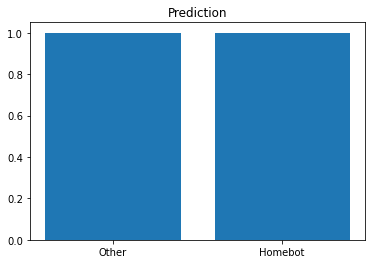

In [64]:
commands = ['Other', 'Homebot']
plt.bar(commands, tf.nn.softmax(prediction[0]))
plt.title('Prediction')
plt.show